In [1]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

import numpy as np
import pandas as pd

import model_predict
from sklearn.model_selection import train_test_split

In [2]:
series, scaler = model_predict.read_data_series(scale=True, filter_early=False, file_index=1)

时间序列连贯


In [3]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUModel, self).__init__()
        input_size = 1
        self.cn = nn.Conv1d(input_size, input_size, 3, padding=1)
        self.gru = nn.GRU(input_size, hidden_size,
                          num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x[:, :, 0].unsqueeze(2)
        x = self.cn(x.permute(0, 2, 1)).permute(0, 2, 1)
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])  # 使用最后一个时间步的输出
        return out


model_parameters = {
    "input_size": 3, "hidden_size": 16, "num_layers": 1, "output_size": 1
}

In [4]:
from importlib import reload
reload(model_predict)
model_predict.train_rnn_model(GRUModel, model_parameters, series, epochs=600)

训练 GRUModel 模型
结果保存到： GRUModel_best.pth
Epoch [50/600], Learn Rate: 1.0000e-03, Training Loss: 0.7329, Validation Loss: 0.5040
Epoch [100/600], Learn Rate: 1.0000e-03, Training Loss: 0.4741, Validation Loss: 0.4245
Epoch [150/600], Learn Rate: 1.0000e-03, Training Loss: 0.4207, Validation Loss: 0.3785
Epoch [200/600], Learn Rate: 1.0000e-03, Training Loss: 0.3932, Validation Loss: 0.3465
Epoch [250/600], Learn Rate: 1.0000e-03, Training Loss: 0.3631, Validation Loss: 0.3199
Epoch [300/600], Learn Rate: 1.0000e-03, Training Loss: 0.2856, Validation Loss: 0.3311
Epoch [350/600], Learn Rate: 1.0000e-03, Training Loss: 0.2596, Validation Loss: 0.3440
Epoch [400/600], Learn Rate: 1.0000e-03, Training Loss: 0.2345, Validation Loss: 0.3587
Epoch [450/600], Learn Rate: 1.0000e-03, Training Loss: 0.2023, Validation Loss: 0.3414
Epoch [500/600], Learn Rate: 1.0000e-03, Training Loss: 0.1600, Validation Loss: 0.3066
Epoch [550/600], Learn Rate: 1.0000e-03, Training Loss: 0.1276, Validation Loss: 

从2019年9月开始后续数据推理
MSE: 948.27
MAE: 24.95
R^2: 0.18
MAPE: 0.53


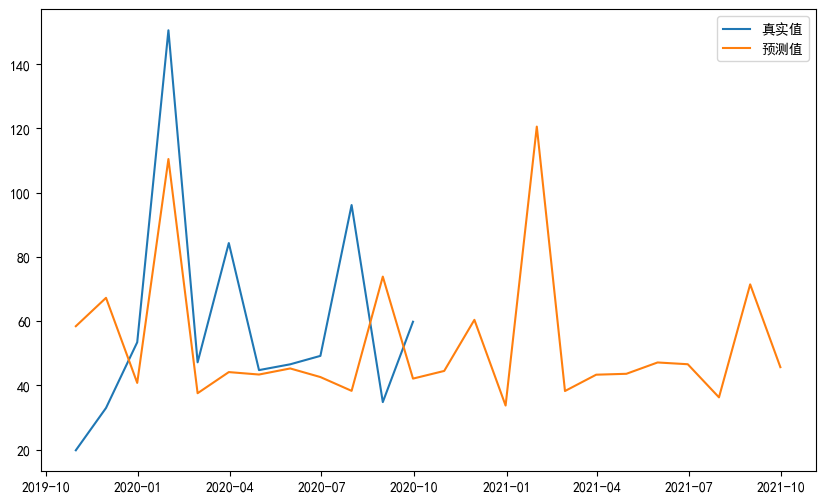

array([ 58.42250559,  67.25604131,  40.76694234, 110.47813876,
        37.55675636,  44.13371731,  43.3757324 ,  45.26841641,
        42.58842195,  38.29185223,  73.86775696,  42.10628674,
        44.49232102,  60.40737636,  33.71909085, 120.57895514,
        38.24024754,  43.32306483,  43.60366938,  47.13031821,
        46.58114133,  36.26711292,  71.44832693,  45.66581394])

In [5]:
model = model_predict.load_rnn_model_best(GRUModel, model_parameters)
model_predict.predict_to_future_rnn(model, series, scaler, last_months=12)